<a href="https://colab.research.google.com/github/Fyfy1996/Natural_language_understanding/blob/master/HW1_Part2_Spam_Classification_with_LSTM_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Classification Part 2

The deadline for Part 1 is **2 pm Feb 19, 2020**.   
You should submit a `.ipynb` file with your solutions to NYU Classes.

---

In this homework, we will reuse the spam prediction dataset used in HW1-Part1.
We will use a word-level BiLSTM sentence encoder to encode the sentence and a neural network classifier.

For reference, you may read [this paper](https://arxiv.org/abs/1705.02364).



# Data Loading
First, reuse the code from HW1-Part1 to download and read the data.

In [0]:
!wget 'https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR' -O spam.csv

--2020-02-19 03:11:16--  https://docs.google.com/uc?export=download&id=1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR
Resolving docs.google.com (docs.google.com)... 74.125.142.100, 74.125.142.101, 74.125.142.138, ...
Connecting to docs.google.com (docs.google.com)|74.125.142.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1ncedoqf403bjh6pfnnedoit8906t5b8/1582081200000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download [following]
--2020-02-19 03:11:21--  https://doc-14-04-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/1ncedoqf403bjh6pfnnedoit8906t5b8/1582081200000/08752484438609855375/*/1OVRo37agn02mc6yp5p6-wtJ8Hyb-YMXR?e=download
Resolving doc-14-04-docs.googleusercontent.com (doc-14-04-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-14-04-docs.googleusercontent.com (doc-14-04-d

In [0]:
import pandas as pd
import numpy as np

df = pd.read_csv("spam.csv", usecols=["v1", "v2"], encoding='latin-1')
# 1 - spam, 0 - ham
df.v1 = (df.v1 == "spam").astype("int")
df.head()

,v1,v2
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


We will split the data into train, val, and test sets.  
`train_texts`, `val_texts`, and `test_texts` should contain a list of text examples in the dataset.


In [0]:
# 0.15 for val, 0.15 for test, 0.7 for train
val_size = int(df.shape[0] * 0.15)
test_size = int(df.shape[0] * 0.15)

# Shuffle the data
df = df.sample(frac=1)
# Split df to test/val/train
test_df = df[:test_size]
val_df = df[test_size:test_size+val_size]
train_df = df[test_size+val_size:]


train_texts, train_labels = list(train_df.v2), list(train_df.v1)
val_texts, val_labels     = list(val_df.v2), list(val_df.v1)
test_texts, test_labels   = list(test_df.v2), list(test_df.v1)


# Check that idces do not overlap
assert set(train_df.index).intersection(set(val_df.index)) == set({})
assert set(test_df.index).intersection(set(train_df.index)) == set({})
assert set(val_df.index).intersection(set(test_df.index)) == set({})
# Check that all idces are present
assert df.shape[0] == len(train_labels) + len(val_labels) + len(test_labels)

# Sizes
print(
    f"Size of initial data: {df.shape[0]}\n"
    f"Train size: {len(train_labels)}\n"
    f"Val size: {len(val_labels)}\n"
    f"Test size: {len(test_labels)}\n"
)

Size of initial data: 5572
Train size: 3902
Val size: 835
Test size: 835



In [0]:
train_texts[:10] # Just checking the examples in train_text

['Im done. Just studyn in library',
 "Dude. What's up. How Teresa. Hope you have been okay. When i didnt hear from these people, i called them and they had received the package since dec  &lt;#&gt; . Just thot you'ld like to know. Do have a fantastic year and all the best with your reading. Plus if you can really really Bam first aid for Usmle, then your work is done.",
 'Its a part of checking IQ',
 'PRIVATE! Your 2003 Account Statement for 07973788240 shows 800 un-redeemed S. I. M. points. Call 08715203649 Identifier Code: 40533 Expires 31/10/04',
 'Download as many ringtones as u like no restrictions, 1000s 2 choose. U can even send 2 yr buddys. Txt Sir to 80082 å£3 ',
 'You are a winner you have been specially selected to receive å£1000 cash or a å£2000 award. Speak to a live operator to claim call 087123002209am-7pm. Cost 10p',
 "Yes i have. So that's why u texted. Pshew...missing you so much",
 'What do u want when i come back?.a beautiful necklace as a token of my heart for you.

# Download and Load GloVe Embeddings
We will use GloVe embeddings as our word representations.  
Let's download and load glove. We will reuse the code from Lab 2 for downloading and loading GloVe


In [0]:
#@title Download GloVe word embeddings

# === Download GloVe word embeddings
# !wget http://nlp.stanford.edu/data/glove.6B.zip

# === Unzip word embeddings and use only the top 50000 word embeddings for speed
# !unzip glove.6B.zip
# !head -n 50000 glove.6B.300d.txt > glove.6B.300d__50k.txt

# === Download Preprocessed version
!wget https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu -O glove_split.aa
!wget https://docs.google.com/uc?id=1LF2yD2jToXriyD-lsYA5hj03f7J3ZKaY -O glove_split.ab
!wget https://docs.google.com/uc?id=1N1xnxkRyM5Gar7sv4d41alyTL92Iip3f -O glove_split.ac
!cat glove_split.?? > 'glove.6B.300d__50k.txt'

--2020-02-19 03:11:22--  https://docs.google.com/uc?id=1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving docs.google.com (docs.google.com)... 173.194.202.102, 173.194.202.100, 173.194.202.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.202.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6q4krp99hg1i1tv51n341av8i6ohlfmq/1582081200000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu [following]
--2020-02-19 03:11:26--  https://doc-0k-0g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6q4krp99hg1i1tv51n341av8i6ohlfmq/1582081200000/14514704803973256873/*/1KMJTagaVD9hFHXFTPtNk0u2JjvNlyCAu
Resolving doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)... 74.125.142.132, 2607:f8b0:400e:c08::84
Connecting to doc-0k-0g-docs.googleusercontent.com (doc-0k-0g-docs.googleusercontent.com)|74.125.

## Load GloVe Embeddings

We are going to reuse the code from Lab 2 here. In addition, we will add a padding token and an unknown token to our vocabulary.

In [0]:
def load_glove(glove_path, embedding_dim):
    with open(glove_path) as f:
        token_ls = [PAD_TOKEN, UNK_TOKEN]
        embedding_ls = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            token, raw_embedding = line.split(maxsplit=1)
            token_ls.append(token)
            embedding = np.array([float(x) for x in raw_embedding.split()])
            embedding_ls.append(embedding)
        embeddings = np.array(embedding_ls)
    return token_ls, embeddings

PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
EMBEDDING_DIM  = 300 # dimension of Glove embeddings
glove_path = "glove.6B.300d__50k.txt"
vocab, embeddings = load_glove(glove_path, EMBEDDING_DIM)

## Import packages

In [0]:
!pip install sacremoses

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import os
import pandas as pd
import sacremoses
from torch.utils.data import dataloader, Dataset
import tqdm

     |████████████████████████████████| 870kB 5.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.38-cp36-none-any.whl size=884628 sha256=5ee341472e70fd4a803c47713c335e6a7028a30c43250a05e34ca6020f6fa2c1
  Stored in directory: /root/.cache/pip/wheels/6d/ec/1a/21b8912e35e02741306f35f66c785f3afe94de754a0eaf1422
Successfully built sacremoses


# Featurize text data.
We will reuse the `featurize` function from Lab 2 to convert text data into features.

In [0]:
def featurize(data, labels, tokenizer, vocab, max_seq_length=128):
    vocab_to_idx = {word: i for i, word in enumerate(vocab)}
    text_data = []
    label_data = []
    for ex in tqdm.tqdm_notebook(data):
        tokenized = tokenizer.tokenize(ex.lower())
        ids = [vocab_to_idx.get(token, 1) for token in tokenized]
        text_data.append(ids)
    return text_data, labels
tokenizer = sacremoses.MosesTokenizer()
train_data_indices, train_labels = featurize(train_texts, train_labels, tokenizer, vocab)
val_data_indices, val_labels = featurize(val_texts, val_labels, tokenizer, vocab)
test_data_indices, test_labels = featurize(test_texts, test_labels, tokenizer, vocab)

In [0]:
print("\nTrain text first 5 examples:\n", train_data_indices[:5])
print("\nTrain labels first 5 examples:\n", train_labels[:5])


Train text first 5 examples:
 [[14665, 1, 122, 1, 8, 2231], [1, 104, 1, 1, 199, 1, 826, 83, 35, 53, 1, 63, 43, 1, 2273, 27, 160, 71, 3, 43, 177, 103, 7, 41, 42, 498, 2, 2085, 110, 13287, 725, 18811, 91, 2751, 725, 16537, 91, 4, 122, 1, 83, 1, 119, 6, 1, 90, 35, 9, 7874, 64, 7, 66, 2, 256, 19, 394, 1, 2260, 85, 83, 88, 590, 590, 19080, 60, 844, 12, 1, 3, 129, 394, 163, 16, 753, 4], [49, 9, 155, 5, 7325, 21947], [674, 807, 394, 784, 1532, 376, 12, 1, 972, 3787, 1, 2562, 6935, 2552, 1, 582, 1, 34931, 2282, 47, 1, 9284, 1247, 276, 208, 276, 14904], [8357, 21, 111, 1, 21, 6481, 119, 86, 3254, 3, 1, 234, 1, 6481, 88, 153, 1547, 234, 1, 1, 1, 2701, 6, 1, 1, 4552, 316]]

Train labels first 5 examples:
 [0, 0, 0, 1, 1]


# Create DataLoaders
 Now, let's create pytorch DataLoaders for our train, val, and test data.
 You can reference Lab 2.

 `SpamDataset` class is similar to `TextDataset` from Lab 2. But it has an additional parameter called `self.max_sent_length` and a `spam_collate_func`.  

`spam_collate_func` is supposed to dynamically pad or trim the sentences in the batch based on `self.max_sent_length` and the length of longest sequence in the batch.
- If `self.max_sent_length` is greater than the length of longest sequence in the batch, use `self.max_sent_length`. Otherwise, use the length of longest sequence in the batch.
- We do this because sometimes, our input sentences in the batch may be much shorter than `self.max_sent_length`.  



In [0]:
import numpy as np
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, target_list, max_sent_length=128):
        """
        @param data_list: list of data tokens 
        @param target_list: list of data targets 

        """
        self.data_list = data_list
        self.target_list = target_list
        self.max_sent_length = max_sent_length
        assert (len(self.data_list) == len(self.target_list))

    def __len__(self):
        return len(self.data_list)
        
    def __getitem__(self, key, max_sent_length=None):
        """
        Triggered when you call dataset[i]
        """
        if max_sent_length is None:
            max_sent_length = self.max_sent_length
        token_idx = self.data_list[key][:max_sent_length]
        label = self.target_list[key]
        return [token_idx, label]

    def spam_collate_func(self,batch):
        """
        Customized function for DataLoader that dynamically pads the batch so that all 
        data have the same length
        """ 
        data_list = [] # store padded sequences
        label_list = []
        # the length of longest sequence in batch
        # if it is less than self.max_sent_length.
        # else max_batch_seq_len = self.max_sent_length 
        

        """
          # Pad the sequences in your data 
          # if their length is less than max_batch_seq_len
          # or trim the sequences that are longer than self.max_sent_length
          # return padded data_list and label_list
          1. TODO: Your code here 
        """
        
        batch_data = [item[0] for item in batch]
        label_list = [item[1] for item in batch]
        max_batch_seq_len = min(self.max_sent_length,max([len(k) for k in batch_data]) )      

        for row in batch_data:
            if len(row) <= max_batch_seq_len:
                new_row = row + [0] * (max_batch_seq_len - len(row))
            else:
                new_row = row
            
            new_row = new_row[:max_sent_length]
            data_list.append(new_row)
          
        data_list = torch.tensor(data_list)
        #label_list = torch.tensor(to_one_hot_vector(2, np.array(label_list)))
        label_list = torch.tensor(label_list)
        return [data_list, label_list]

BATCH_SIZE = 64
max_sent_length=128
train_dataset = SpamDataset(train_data_indices, train_labels, max_sent_length)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=True)

val_dataset = SpamDataset(val_data_indices, val_labels, train_dataset.max_sent_length)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)

test_dataset = SpamDataset(test_data_indices, test_labels, train_dataset.max_sent_length)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                           batch_size=BATCH_SIZE,
                                           collate_fn=train_dataset.spam_collate_func,
                                           shuffle=False)



Let's try to print out an example batch from train_loader.


In [0]:
data_batch, labels = next(iter(train_loader))
print("data batch dimension: ", data_batch.size())
print("data_batch: ", data_batch)
print("labels: ", labels)

data batch dimension:  torch.Size([64, 85])
data_batch:  tensor([[  328,   139,     6,  ...,     0,     0,     0],
        [ 6481,    88,   322,  ...,     0,     0,     0],
        [ 3526,     1,    99,  ...,     0,     0,     0],
        ...,
        [    1,     1,    53,  ...,     0,     0,     0],
        [   43,   915,    38,  ...,     0,     0,     0],
        [34857,    14,    16,  ...,     0,     0,     0]])
labels:  tensor([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])


# Build a BiLSTM Classifier

Now we are going to build a BiLSTM classifier. Check this [blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) and [`torch.nn.LSTM`](https://pytorch.org/docs/stable/nn.html?highlight=lstm#torch.nn.LSTM) for reference.  

The hyperparameters for LSTM are already given, but I did not do hyperparameter tuning. You should get a good accuracy with these hyperparameters but you may try to tune the hyperparameters and use different hyperparameters to get better performance.

In [0]:
# First import torch related libraries
import torch
import torch.nn as nn
import torch.nn.functional as F

class LSTMClassifier(nn.Module):
    """
    LSTMClassifier classification model
    """
    def __init__(self, embeddings, hidden_size, num_layers, num_classes, bidirectional, dropout_prob=0.3):
        super().__init__()
        """
           define the components of your BiLSTM Classifier model
           You may refer to Lab2 for reference
           2. TODO: Your code here
        """
        self.embedding_layer = self.load_pretrained_embeddings(embeddings)
        self.dropout = nn.Dropout(p = dropout_prob)
        self.lstm = nn.LSTM(input_size = 300, hidden_size = hidden_size, num_layers = num_layers, batch_first=True,
                            dropout=dropout_prob, bidirectional=bidirectional)
        self.non_linearity = nn.ReLU()                                            # For example, ReLU
        self.lm = nn.Linear(hidden_size, num_classes)
        #self.softmax = nn.Softmax(dim=num_classes)                                      # classifier layer
        
        
        pass
    
    def load_pretrained_embeddings(self, embeddings):
        """
           The code for loading embeddings from Lab 2
           Unlike lab, we are not setting `embedding_layer.weight.requires_grad = False`
           because we want to finetune the embeddings on our data
        """
        embedding_layer = nn.Embedding(embeddings.shape[0], embeddings.shape[1], padding_idx=0)
        embedding_layer.weight.data = torch.Tensor(embeddings).float()
        return embedding_layer


    def forward(self, inputs):
        logits = None
        """
           Write forward pass for LSTM
           Example, forward:= embedding -> bilstm -> pooling (sum?mean?max?) 
                              nonlinearity -> classifier
           Refer to: https://arxiv.org/abs/1705.02364 
           Return logits
           You may refer to Lab2 for embedding lookup and how to return logits
           3. TODO: Your code here
        """
        embedded = self.embedding_layer(inputs)
        embedded_droped = self.dropout(embedded)

        after_lstm, _ = self.lstm(embedded_droped)
        
        lstm = after_lstm[:,:,:hidden_size]
        lstm_bidirected = after_lstm[:,:,hidden_size:] 

        lstm_stacked = torch.stack([lstm,lstm_bidirected])
        lstm_max2,cache = torch.max(lstm_stacked, dim=2)
        lstm_max0,cache = torch.max(lstm_max2, dim=0)

        after_lstm_relu = self.non_linearity(lstm_max0)
        after_linear = self.lm(after_lstm_relu)
        logits = after_linear
        #logits = self.softmax(after_linear)

        return logits

First, we will define an evaluation function that will return the accuracy of the model. We will use this to compute validation accuracy and test accuracy of the model given a dataloader.

In [0]:
def evaluate(model, dataloader, device):
    accuracy = None
    model.eval()
    """
        4. TODO: Your code here
        Calculate the accuracy of the model on the data in dataloader
        You may refer to `run_inference` function from Lab2 
    """
    with torch.no_grad():
      correct = 0
      total = 0
      for batch_text, batch_labels in dataloader:
          
          y_pred = F.softmax(model(batch_text.to(device)), dim=1)
          predicted = y_pred.max(1, keepdim=True)[1]
          total += batch_labels.size(0)
          correct += predicted.eq(batch_labels.to(device).view_as(predicted)).sum().item()
    accuracy = correct/total
    
    return accuracy 

# Initialize the BiLSTM classifier model, criterion and optimizer


In [0]:
# BiLSTM hyperparameters
hidden_size = 32
num_layers = 1
num_classes = 2
bidirectional=True
torch.manual_seed(1234)

# if cuda exists, use cuda, else run on cpu
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device('cpu')

model = LSTMClassifier(embeddings, hidden_size, num_layers, num_classes, bidirectional)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:50: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


# Train model with early stopping

Train the model for `NUM_EPOCHS`. 
Keep track of training loss (just like we did in Lab 2).  
Compute the validation accuracy after each epoch. Keep track of the best validation accuracy and save the model with the best validation accuracy.  

If the validation accuracy does not improve for more than `early_stop_patience` times in a row, stop training. 


In [0]:
train_loss_history = []
val_accuracy_history = []
best_val_accuracy = 0
n_no_improve = 0
early_stop_patience=2
NUM_EPOCHS=10
  
for epoch in tqdm.tqdm_notebook(range(NUM_EPOCHS)):
    model.train()# this enables regularization, which we don't currently have
    for i, (data_batch, batch_labels) in enumerate(train_loader):
        """
           Code for training lstm
           Keep track of training of for each batch using train_loss_history
        """
        preds = model(data_batch.to(device))
        loss = criterion(preds, batch_labels.to(device))
        loss.backward(retain_graph=True)
        optimizer.step()
        optimizer.zero_grad()
        train_loss_history.append(loss.item())

        
    # The end of a training epoch 

    """
        Code for tracking best validation accuracy, saving the best model, and early stopping
        # Compute validation accuracy after each training epoch using `evaluate` function
        # Keep track of validation accuracy in `val_accuracy_history`
        # save model with best validation accuracy, hint: torch.save(model, 'best_model.pt')
        # Early stopping: 
        # stop training if the validation accuracy does not improve for more than `early_stop_patience` runs
        5. TODO: Your code here
    """
    prev_acc = 0
    val_accuracy = evaluate(model, val_loader, device)
    val_accuracy_history.append(val_accuracy)
    
    if val_accuracy > best_val_accuracy:
      torch.save(model, "best_model.pt")
      best_val_accuracy = val_accuracy
    else:
      n_no_improve += 1
    if n_no_improve > early_stop_patience:
      print("No improvement")
      break

print("Best validation accuracy is: ", best_val_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LSTMClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


No improvement

Best validation accuracy is:  0.9940119760479041


#Question: Why do we want to use early stopping?
Your answer:
While the training itertations increase and the accuracy rate in training set keeps going up, the accuracy rate in validation/test set will increase and then decrease at some point because the model is learning noise from the training set. Early stopping can prevent overfitting, which is similiar to L1/L2 regulation. While sometimes the accuracy rate of val/test set will go up again after going down a little, the early stopping is actually a balance between computational resource / time and accuracy.

# Draw training curve 
X-axis: training steps, Y-axis: training loss

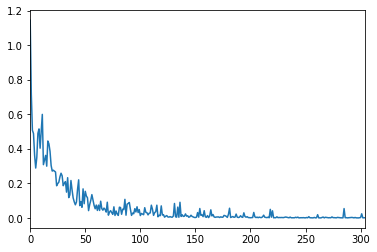

In [0]:
pd.Series(train_loss_history).plot()

# Validation accuracy curve
X-axis: Epochs, Y-axis: validation accuracy

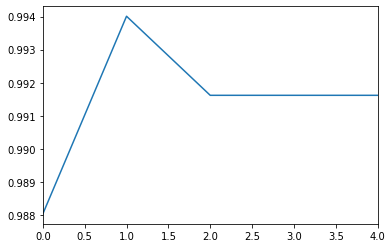

In [0]:
pd.Series(val_accuracy_history).plot()

## You should expect to get test accuracy >= 95.

In [0]:
# Reload best model from saved checkpoint
# Compute test accuracy
model = torch.load('best_model.pt')
test_accuracy = evaluate(model, test_loader, device)
print(test_accuracy)

0.9916167664670659


## Optional Bonus Questions: 
(If you scored full mark (100) in all previous sections, you won't get additional marks so you probably won't need this. But you will get additional bonus marks for answering this if your score is below 100.)

1. What are the problems with recurrent neural networks (RNNs) and how do we overcome them?

2. What is the benefit of using the mean or max pooling of hidden states of LSTM instead of using the last hidden state of LSTM?

## Answers:
1. While training a vanilla RNN, it is hard for backpropagation through time (BPTT) to deal with long-term dependency on previous sequences, which will bring gradient vanishing or gradient explosion. LSTM can deal with this problem.

2. Pooling can keep the main characteristics unchanged while reduce the numbers of parameters to be trained in a model.




